## Introducción a PyTorch (Parte 7)

<a target="_blank" href="https://colab.research.google.com/github/pglez82/DeepLearningWeb/blob/master/labs/notebooks/Introducci%C3%B3n%20a%20PyTorch%20(Parte%207).ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

En este notebook vamos a aprender como realizar un fine-tuning de un modelo. En este caso será un modelo de texto conocido como Bert. Puedes encontrar más información acerca de Bert en este [enlace](https://huggingface.co/docs/transformers/v4.30.0/en/model_doc/bert#transformers.BertForSequenceClassification).

### Instalación de los paquetes necesarios para la ejecución del notebook
En este caso necesitamos la librería transformers (Bert es un transformer) y la librería dataset para cargar el dataset que utilizaremos.

In [1]:
!pip install transformers
!pip install datasets

### Carga del dataset
El dataset a utilizar en este caso será SST2. El conjunto de datos SST-2 (Stanford Sentiment Treebank 2) es un conjunto de datos ampliamente utilizado para tareas de análisis de sentimientos en el procesamiento del lenguaje natural. Consiste en reseñas de películas en inglés y su objetivo es determinar si una reseña tiene un sentimiento positivo o negativo.

In [2]:
from datasets import load_dataset

# Cargar el dataset
dataset = load_dataset('sst')

train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

print(train_dataset)
print(val_dataset)
print(test_dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['sentence', 'label', 'tokens', 'tree'],
    num_rows: 8544
})
Dataset({
    features: ['sentence', 'label', 'tokens', 'tree'],
    num_rows: 1101
})
Dataset({
    features: ['sentence', 'label', 'tokens', 'tree'],
    num_rows: 2210
})


### Procesado y visualización de datos
En este dataset la etiqueta es un número de real, que va de 0 a 1, según la opinión sea negativa (cercano a cero) o positiva (cercano a uno). Nosotros vamos a convertir este problema a un problema binario, considerando que las opiniones con más de 0.5, son positivas y viceversa.

In [3]:
from torch.utils.data import Dataset
from transformers import BertTokenizer
import torch

# Creamos un dataset específico para nuestro problema
class SST2Dataset(Dataset):
    def __init__(self, sentences, labels, tokenizer):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.encodings = tokenizer(sentences, truncation=True, padding=True)
        self.labels = [1 if label>=0.5 else 0 for label in labels]

    def __getitem__(self, idx):
        #Para un elemento dado devolvemos las tres cosas que nos devuelve el tokenizer: input_ids, token_type_ids y attention_masks
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        item['sentence'] = self.sentences[idx]
        return item

    def __len__(self):
        return len(self.labels)

base_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(base_model_name)
train_dataset = SST2Dataset(train_dataset['sentence'],train_dataset['label'], tokenizer=tokenizer)

Como puedes ver en el código anterior, hemos creado un Dataset específico para procesar los datos de nuestro problema. En el constructor tokenizamos todas las frases del dataset. El tokenizador nos devuelve tres elementos, que posteriormente devolveremos cuando se nos pida un elemento del dataset:
- input_ids: Son identificadores numéricos que representan los tokens de entrada después de ser procesados por el tokenizer.
- token_type_ids: Son identificadores que indican la pertenencia de cada token a una cierta segmentación o "tipo" en modelos que manejan múltiples secuencias de entrada.
- attention_masks: Es una máscara binaria que indica qué tokens deben ser atendidos (valor 1) y cuáles deben ser ignorados (valor 0) durante la atención del modelo.

Además devolvemos:
- label: la etiqueta del ejemplo
- sentence: la frase original (no se necesita para el entrenamiento)

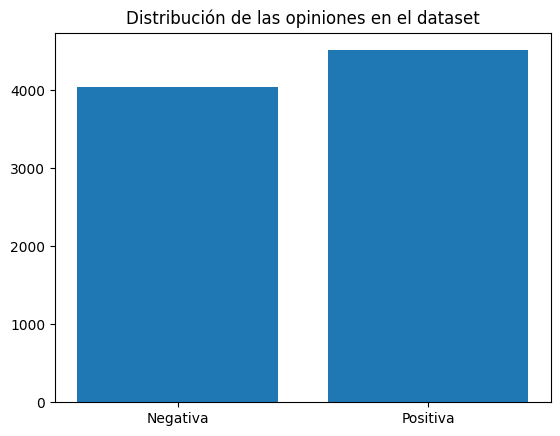

In [4]:
import matplotlib.pyplot as plt

count_0 = train_dataset.labels.count(0)
count_1 = train_dataset.labels.count(1)

# Plotting
labels = ['Negativa', 'Positiva']
counts = [count_0, count_1]

plt.bar(labels, counts)
plt.title('Distribución de las opiniones en el dataset')
plt.show()



### Carga del modelo base y fine-tuning

Vamos ahora a ajustar este modelo de lenguaje a nuestro problema en concreto (también se le conoce como downstream task). Haremos un bucle de entrenamiento típico como hemos visto en prácticas anteriores.

In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader


model = BertForSequenceClassification.from_pretrained(base_model_name)

# Crear dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando el dispositivo %s" % device)

model.to(device)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 3

for epoch in range(num_epochs):
    epoch_loss = 0
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        if step%10==0:
            print("Step %d/%d" % (step,len(train_dataloader)))
    print("Training Loss %0.2f" % (epoch_loss/len(train_dataloader)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Usando el dispositivo cuda
Step 0/67
Step 10/67
Step 20/67
Step 30/67
Step 40/67
Step 50/67
Step 60/67
Training Loss 0.56
Step 0/67
Step 10/67
Step 20/67
Step 30/67
Step 40/67
Step 50/67
Step 60/67
Training Loss 0.36
Step 0/67
Step 10/67
Step 20/67
Step 30/67
Step 40/67
Step 50/67
Step 60/67
Training Loss 0.28


### Inferencia
Ahora que hemos entrenado el modelo podemos predecir el conjunto de test para ver que tal funciona:

In [6]:
test_dataset = SST2Dataset(test_dataset['sentence'],test_dataset['label'], tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
model.eval()
correct_predictions=0
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_labels = torch.argmax(predicted_probabilities, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()

print("Acierto: %2.f" % (correct_predictions/len(test_dataset)))

Acierto:  1


Como puedes ver este problema es muy sencillo para un modelo tan potente como Bert y con un simple finetuning podemos resolverlo fácilmente.

### Ejercicios

1. Que error daría la red sin hacer fine-tuning?
2. Añade un bucle de validación y early stopping.
3. Añade código necesario para monitorizar el error de entrenamiento y de validación.
4. Añade el código necesario para salvar el mejor modelo entrenado.
5. Cambia el código para convertir el código en un problema multiclase de tres clases. En este caso, las opiniones en el rango [0, 0.3] serán negativas, las opiniones en el rango (0.3,0.7) serán neutras y las opiniones en el rango [0.7,1] serán positivas.
6. ¿Cuántos datos son necesarios para realizar un fine-tuning efectivo? Reduce el número de frases de entrenamiento y crea un estudio de cuantos datos harían falta para que nuestro sistema siguiese funcionando bien.